In [22]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series specific plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Statistical tests for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

# Classical time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
import arff
import pandas as pd

# Load ARFF file
with open("dataset.arff") as f:
    dataset = arff.load(f)

# Extract into a DataFrame
df = pd.DataFrame(dataset["data"], columns=[attr[0] for attr in dataset["attributes"]])

print(df.head())
print(df.info())



   No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     4

In [24]:
df["datetime"] = pd.to_datetime(df[["year","month","day","hour"]])
df = df.set_index("datetime").sort_index()
df = df.drop(columns=["No","year","month","day","hour"])

In [25]:
df.isna().sum()


PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

In [26]:
df = df.groupby("station").apply(lambda g: g.interpolate(method="time")).reset_index(level=0, drop=True)


In [27]:
df = df.fillna(method="ffill").fillna(method="bfill")


In [28]:
df["wd"] = df.groupby("station")["wd"].fillna(method="ffill")
df["wd"] = df.groupby("station")["wd"].fillna(method="bfill")


In [29]:
print(df.isna().sum())


PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64


In [30]:
import numpy as np
wind_map = {'N':0,'NNE':22.5,'NE':45,'ENE':67.5,'E':90,'ESE':112.5,'SE':135,'SSE':157.5,
            'S':180,'SSW':202.5,'SW':225,'WSW':247.5,'W':270,'WNW':292.5,'NW':315,'NNW':337.5}
df["wd_deg"] = df["wd"].map(wind_map)
df["wd_sin"] = np.sin(np.deg2rad(df["wd_deg"]))
df["wd_cos"] = np.cos(np.deg2rad(df["wd_deg"]))
df = df.drop(columns=["wd","wd_deg"])


In [31]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [32]:
print(train.columns)


Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'station', 'wd_sin', 'wd_cos'],
      dtype='object')


In [33]:

# Select target variable and prepare station-specific data
target_var = 'PM2.5'  # You can change this to any pollutant you want to forecast

# Get unique stations
stations = df['station'].unique()
print(f"Available stations: {stations}")

# Let's focus on one station first for modeling
station_name = 'Aotizhongxin'  # Change this to any station you prefer
station_data = df[df['station'] == station_name].copy()

print(f"\nData for station {station_name}:")
print(f"Shape: {station_data.shape}")
print(f"Date range: {station_data.index.min()} to {station_data.index.max()}")

# Create proper time-based train/test split for this station
train_size = int(len(station_data) * 0.8)
station_train = station_data.iloc[:train_size]
station_test = station_data.iloc[train_size:]

# Prepare features and target
feature_cols = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_sin', 'wd_cos']
X_train = station_train[feature_cols]
y_train = station_train[target_var]
X_test = station_test[feature_cols]
y_test = station_test[target_var]

print(f"\nTraining set:")
print(f"  Shape: {X_train.shape}")
print(f"  Date range: {X_train.index.min()} to {X_train.index.max()}")
print(f"\nTest set:")
print(f"  Shape: {X_test.shape}")
print(f"  Date range: {X_test.index.min()} to {X_test.index.max()}")

# Check for any remaining missing values
print(f"\nMissing values in training features: {X_train.isnull().sum().sum()}")
print(f"Missing values in training target: {y_train.isnull().sum()}")
print(f"Missing values in test features: {X_test.isnull().sum().sum()}")
print(f"Missing values in test target: {y_test.isnull().sum()}")

# Basic statistics of the target variable
print(f"\nTarget variable ({target_var}) statistics:")
print(y_train.describe())

Available stations: ['Aotizhongxin' 'Changping' 'Dingling' 'Dongsi' 'Guanyuan' 'Gucheng'
 'Huairou' 'Nongzhanguan' 'Shunyi' 'Tiantan' 'Wanliu' 'Wanshouxigong']

Data for station Aotizhongxin:
Shape: (35064, 14)
Date range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00

Training set:
  Shape: (28051, 12)
  Date range: 2013-03-01 00:00:00 to 2016-05-12 18:00:00

Test set:
  Shape: (7013, 12)
  Date range: 2016-05-12 19:00:00 to 2017-02-28 23:00:00

Missing values in training features: 0
Missing values in training target: 0
Missing values in test features: 0
Missing values in test target: 0

Target variable (PM2.5) statistics:
count    28051.000000
mean        83.269292
std         81.523853
min          3.000000
25%         23.000000
50%         59.000000
75%        116.000000
max        898.000000
Name: PM2.5, dtype: float64


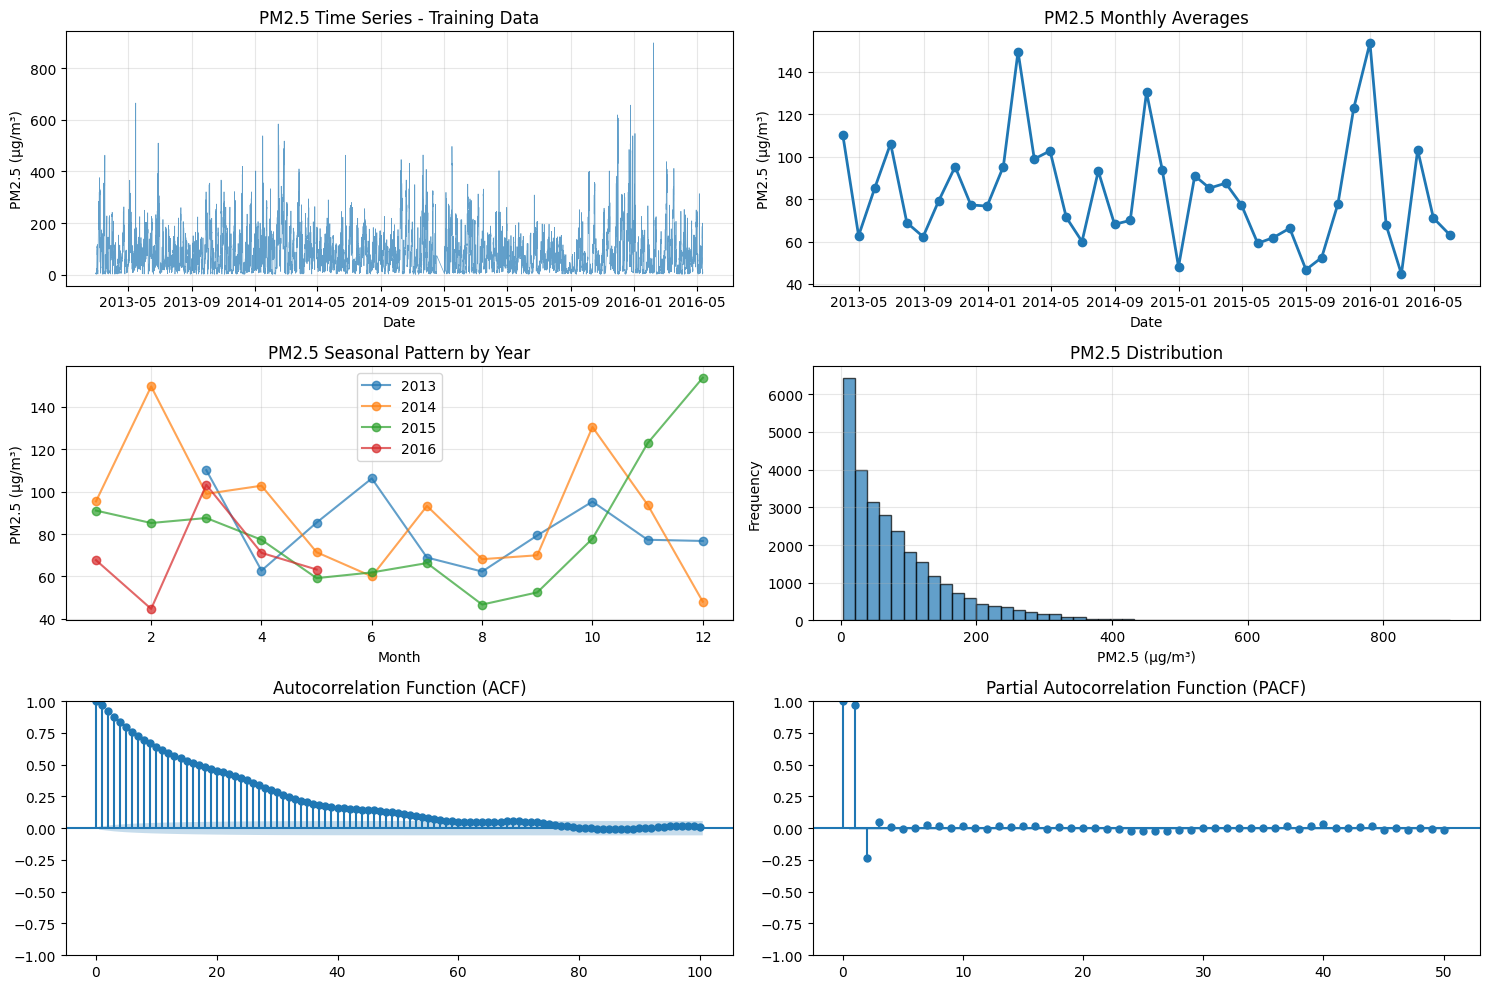

STATIONARITY TESTS

1. Augmented Dickey-Fuller Test:
ADF Statistic: -17.295311
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: Reject null hypothesis. Time series is stationary.

2. KPSS Test:
KPSS Statistic: 0.220342
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: Fail to reject null hypothesis. Time series is stationary.

STATIONARITY SUMMARY
✓ Both tests indicate the series is STATIONARY

Recommendation: Proceed with modeling


In [34]:
# Time series visualization and stationarity testing
plt.figure(figsize=(15, 10))

# Plot 1: Full time series
plt.subplot(3, 2, 1)
plt.plot(y_train.index, y_train.values, alpha=0.7, linewidth=0.5)
plt.title(f'{target_var} Time Series - Training Data')
plt.xlabel('Date')
plt.ylabel(f'{target_var} (μg/m³)')
plt.grid(True, alpha=0.3)

# Plot 2: Monthly averages to see seasonal patterns
monthly_avg = y_train.resample('M').mean()
plt.subplot(3, 2, 2)
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2)
plt.title(f'{target_var} Monthly Averages')
plt.xlabel('Date')
plt.ylabel(f'{target_var} (μg/m³)')
plt.grid(True, alpha=0.3)

# Plot 3: Seasonal decomposition-like plot (yearly pattern)
plt.subplot(3, 2, 3)
for year in range(2013, 2017):
    year_data = y_train[y_train.index.year == year]
    if len(year_data) > 0:
        monthly_year = year_data.resample('M').mean()
        plt.plot(monthly_year.index.month, monthly_year.values, 
                marker='o', label=f'{year}', alpha=0.7)
plt.title(f'{target_var} Seasonal Pattern by Year')
plt.xlabel('Month')
plt.ylabel(f'{target_var} (μg/m³)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Distribution
plt.subplot(3, 2, 4)
plt.hist(y_train.values, bins=50, alpha=0.7, edgecolor='black')
plt.title(f'{target_var} Distribution')
plt.xlabel(f'{target_var} (μg/m³)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 5: ACF
plt.subplot(3, 2, 5)
plot_acf(y_train.values, lags=100, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelation Function (ACF)')

# Plot 6: PACF
plt.subplot(3, 2, 6)
plot_pacf(y_train.values, lags=50, ax=plt.gca(), alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Stationarity Tests
print("STATIONARITY TESTS")

# Augmented Dickey-Fuller Test
print("\n1. Augmented Dickey-Fuller Test:")
adf_result = adfuller(y_train.values, autolag='AIC')
print(f'ADF Statistic: {adf_result[0]:.6f}')
print(f'p-value: {adf_result[1]:.6f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.3f}')

if adf_result[1] <= 0.05:
    print("Result: Reject null hypothesis. Time series is stationary.")
else:
    print("Result: Fail to reject null hypothesis. Time series is non-stationary.")

# KPSS Test
print("\n2. KPSS Test:")
kpss_result = kpss(y_train.values, regression='c', nlags='auto')
print(f'KPSS Statistic: {kpss_result[0]:.6f}')
print(f'p-value: {kpss_result[1]:.6f}')
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'\t{key}: {value:.3f}')

if kpss_result[1] <= 0.05:
    print("Result: Reject null hypothesis. Time series is non-stationary.")
else:
    print("Result: Fail to reject null hypothesis. Time series is stationary.")

# Summary
print("\nSTATIONARITY SUMMARY")
adf_stationary = adf_result[1] <= 0.05
kpss_stationary = kpss_result[1] > 0.05

if adf_stationary and kpss_stationary:
    print("✓ Both tests indicate the series is STATIONARY")
elif not adf_stationary and not kpss_stationary:
    print("✗ Both tests indicate the series is NON-STATIONARY")
else:
    print("⚠ Tests give conflicting results - further investigation needed")

print(f"\nRecommendation: {'Proceed with modeling' if (adf_stationary and kpss_stationary) else 'Consider differencing or other transformations'}")


✓ Data loaded successfully for Aotizhongxin
Training samples: 28051
Test samples: 7013

Testing ARIMA models:
Testing ARIMA(1,0,1)... ✓ AIC: 247478.09, Test MAE: 61.12
Testing ARIMA(2,0,1)... ✓ AIC: 247471.29, Test MAE: 61.13
Testing ARIMA(1,0,2)... ✓ AIC: 247469.63, Test MAE: 61.13
Testing ARIMA(2,0,2)... ✓ AIC: 247464.79, Test MAE: 61.13
Testing ARIMA(1,1,1)... ✓ AIC: 248123.17, Test MAE: 72.30
Testing ARIMA(2,1,1)... ✓ AIC: 247533.23, Test MAE: 58.92

Model Comparison:
       model  p  d  q       AIC       BIC   MAE   RMSE
ARIMA(1,0,1)  1  0  1 247478.09 247511.06 61.12  83.59
ARIMA(2,0,1)  2  0  1 247471.29 247512.50 61.13  83.60
ARIMA(1,0,2)  1  0  2 247469.63 247510.84 61.13  83.60
ARIMA(2,0,2)  2  0  2 247464.79 247514.24 61.13  83.60
ARIMA(1,1,1)  1  1  1 248123.17 248147.90 72.30 110.32
ARIMA(2,1,1)  2  1  1 247533.23 247566.20 58.92  83.66

🏆 Best Model: ARIMA(2, 0, 2)
AIC: 247464.79
Test MAE: 61.13
Test RMSE: 83.60
Train MAE: 10.42
Train RMSE: 19.93


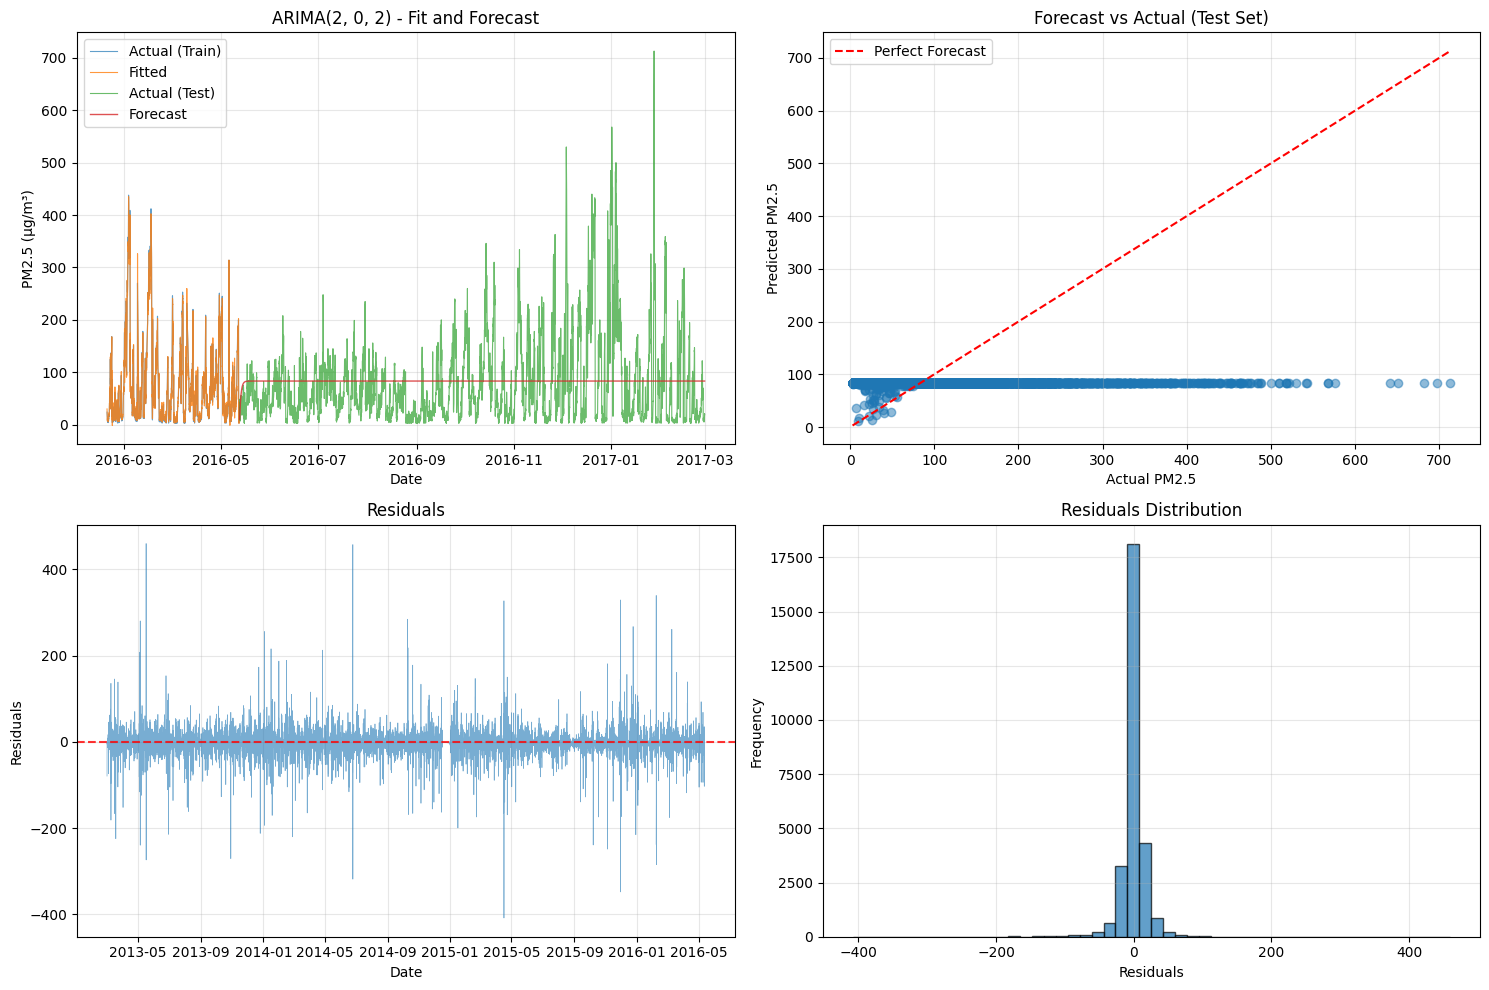


Residual Diagnostics:
Mean of residuals: -0.002608
Std of residuals: 19.93
✓ Residuals appear unbiased (mean ≈ 0)

✅ ARIMA analysis completed!
Results stored in 'arima_results' dictionary


In [35]:
# Fixed ARIMA Analysis - Simple Version
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Check if we have the preprocessed data
try:
    # Data Preparation
    target_var = 'PM2.5'
    station_name = 'Aotizhongxin'
    station_data = df[df['station'] == station_name].copy()
    
    # Create proper time-based train/test split
    train_size = int(len(station_data) * 0.8)
    station_train = station_data.iloc[:train_size]
    station_test = station_data.iloc[train_size:]
    
    # Prepare target variables
    y_train = station_train[target_var]
    y_test = station_test[target_var]
    
    print(f"✓ Data loaded successfully for {station_name}")
    print(f"Training samples: {len(y_train)}")
    print(f"Test samples: {len(y_test)}")
    
except NameError:
    print("❌ Please run your data preprocessing code first!")
    print("You need to have the 'df' DataFrame with preprocessed data.")

def fit_and_evaluate_arima(p, d, q, train_data, test_data):
    """Fit ARIMA model and return metrics"""
    try:
        model = ARIMA(train_data, order=(p, d, q))
        fitted_model = model.fit()
        
        # Forecast
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Metrics
        aic = fitted_model.aic
        bic = fitted_model.bic
        mae = mean_absolute_error(test_data, forecast)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        
        return fitted_model, forecast, aic, bic, mae, rmse, True
    except:
        return None, None, np.inf, np.inf, np.inf, np.inf, False

# Test a few ARIMA models
print("\nTesting ARIMA models:")

models_to_test = [
    (1, 0, 1),
    (2, 0, 1), 
    (1, 0, 2),
    (2, 0, 2),
    (1, 1, 1),
    (2, 1, 1)
]

results = []
best_aic = np.inf
best_model_info = None

for p, d, q in models_to_test:
    print(f"Testing ARIMA({p},{d},{q})... ", end='')
    
    model, forecast, aic, bic, mae, rmse, success = fit_and_evaluate_arima(
        p, d, q, y_train, y_test
    )
    
    if success:
        print(f"✓ AIC: {aic:.2f}, Test MAE: {mae:.2f}")
        results.append({
            'model': f'ARIMA({p},{d},{q})',
            'p': p, 'd': d, 'q': q,
            'AIC': aic, 'BIC': bic,
            'MAE': mae, 'RMSE': rmse
        })
        
        if aic < best_aic:
            best_aic = aic
            best_model_info = {
                'params': (p, d, q),
                'fitted_model': model,
                'forecast': forecast,
                'aic': aic,
                'mae': mae,
                'rmse': rmse
            }
    else:
        print("❌ Failed")

# Display results
if results:
    results_df = pd.DataFrame(results)
    print(f"\nModel Comparison:")
    print(results_df.round(2).to_string(index=False))
    
    # Best model details
    best_params = best_model_info['params']
    best_fitted_model = best_model_info['fitted_model']
    best_forecast = best_model_info['forecast']
    
    print(f"\n🏆 Best Model: ARIMA{best_params}")
    print(f"AIC: {best_model_info['aic']:.2f}")
    print(f"Test MAE: {best_model_info['mae']:.2f}")
    print(f"Test RMSE: {best_model_info['rmse']:.2f}")
    
    # Calculate training metrics
    train_fitted = best_fitted_model.fittedvalues
    train_mae = mean_absolute_error(y_train, train_fitted)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_fitted))
    
    print(f"Train MAE: {train_mae:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}")
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Time series with fit and forecast
    plt.subplot(2, 2, 1)
    
    # Show last 2000 training points for clarity
    plot_start = max(0, len(y_train) - 2000)
    train_subset = y_train.iloc[plot_start:]
    fitted_subset = train_fitted.iloc[plot_start:]
    
    plt.plot(train_subset.index, train_subset.values, 
             label='Actual (Train)', alpha=0.7, linewidth=0.8)
    plt.plot(train_subset.index, fitted_subset.values, 
             label='Fitted', alpha=0.8, linewidth=0.8)
    plt.plot(y_test.index, y_test.values, 
             label='Actual (Test)', alpha=0.7, linewidth=0.8)
    plt.plot(y_test.index, best_forecast, 
             label='Forecast', alpha=0.8, linewidth=1)
    
    plt.title(f'ARIMA{best_params} - Fit and Forecast')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Forecast vs Actual (Test period)
    plt.subplot(2, 2, 2)
    plt.scatter(y_test.values, best_forecast, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', label='Perfect Forecast')
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title('Forecast vs Actual (Test Set)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Residuals
    plt.subplot(2, 2, 3)
    residuals = best_fitted_model.resid
    plt.plot(residuals.index, residuals.values, alpha=0.6, linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
    plt.title('Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Residuals histogram
    plt.subplot(2, 2, 4)
    plt.hist(residuals.values, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Simple residual diagnostics
    residuals_mean = np.mean(residuals)
    residuals_std = np.std(residuals)
    
    print(f"\nResidual Diagnostics:")
    print(f"Mean of residuals: {residuals_mean:.6f}")
    print(f"Std of residuals: {residuals_std:.2f}")
    
    if abs(residuals_mean) < 0.1:
        print("✓ Residuals appear unbiased (mean ≈ 0)")
    else:
        print("⚠ Residuals may be biased")
    
    # Store results
    arima_results = {
        'model': f'ARIMA{best_params}',
        'params': best_params,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'test_mae': best_model_info['mae'],
        'test_rmse': best_model_info['rmse'],
        'aic': best_model_info['aic'],
        'forecast': best_forecast,
        'fitted_model': best_fitted_model
    }
    
    print(f"\n✅ ARIMA analysis completed!")
    print(f"Results stored in 'arima_results' dictionary")
    
else:
    print("❌ No valid ARIMA models could be fitted!")

SARIMA Analysis for Aotizhongxin
Training samples: 28051
Test samples: 7013
Data frequency: Hourly
--------------------------------------------------
Testing SARIMA configurations...
Format: SARIMA(p,d,q)(P,D,Q,s)
------------------------------------------------------------
 1. Testing SARIMA(1,0,1)(1,0,1,24)... ✓ AIC: 247248.7, Test MAE: 58.12
 2. Testing SARIMA(1,0,1)(0,1,1,24)... ✓ AIC: 247042.1, Test MAE: 60.61
 3. Testing SARIMA(1,0,1)(1,1,1,24)... ✓ AIC: 247038.6, Test MAE: 60.66
 4. Testing SARIMA(2,0,1)(1,0,1,24)... ✓ AIC: 247246.4, Test MAE: 57.74
 5. Testing SARIMA(1,0,2)(1,0,1,24)... ✓ AIC: 247235.4, Test MAE: 58.18
 6. Testing SARIMA(1,1,1)(1,0,1,24)... ✓ AIC: 247914.9, Test MAE: 74.41
 7. Testing SARIMA(1,1,1)(0,1,1,24)... ✓ AIC: 247684.3, Test MAE: 80.76
 8. Testing SARIMA(2,1,1)(1,0,1,24)... ✓ AIC: 247322.1, Test MAE: 60.48

📊 SARIMA Model Comparison (sorted by AIC):
                  model       aic  test_mae  test_rmse
SARIMA(1,0,1)(1,1,1,24) 247038.61     60.66      8

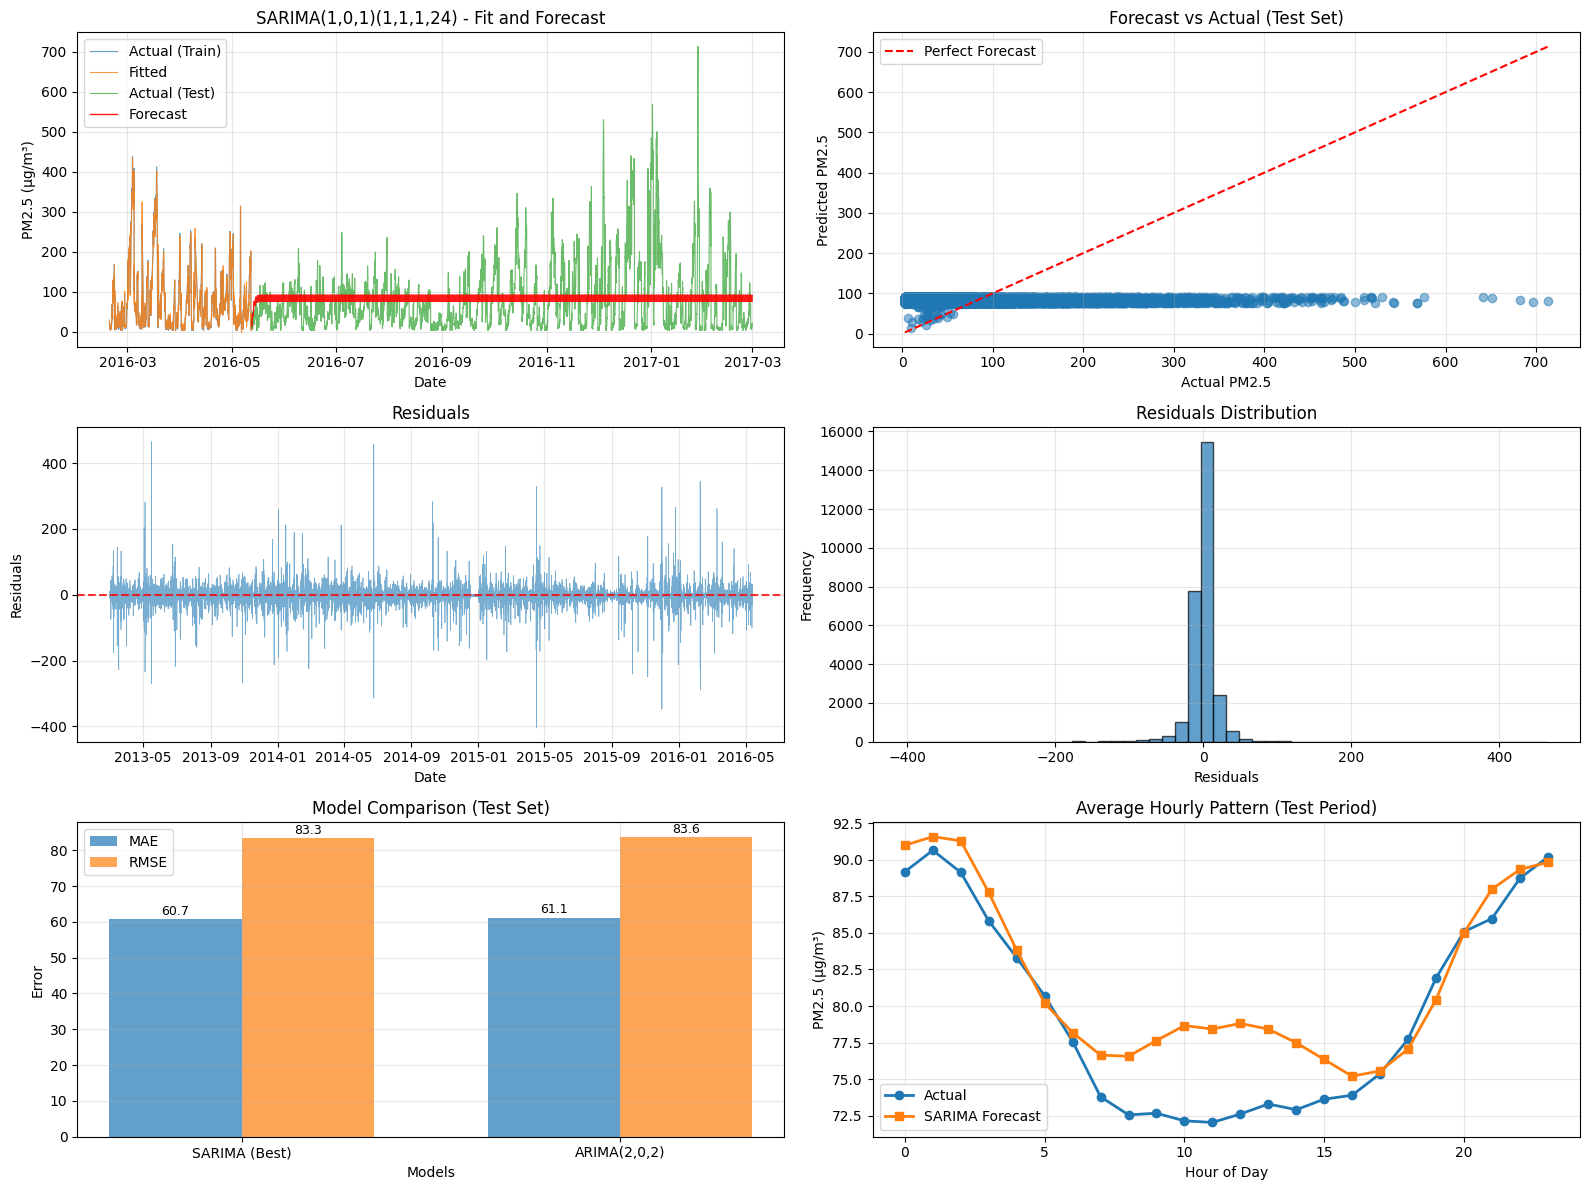


📊 Residual Diagnostics:
------------------------------
Mean of residuals: -0.104718
Std of residuals: 19.92
⚠ Residuals may be biased

✅ SARIMA analysis completed!
Results stored in 'sarima_results' dictionary

📈 Final Model Performance Comparison:
        Model  Test MAE  Test RMSE       AIC
SARIMA (Best)     60.66      83.31 247038.61
 ARIMA(2,0,2)     61.13      83.60 247464.79


In [ ]:
# SARIMA Model Analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data preparation
target_var = 'PM2.5'
station_name = 'Aotizhongxin'
station_data = df[df['station'] == station_name].copy()

# Create train/test split
train_size = int(len(station_data) * 0.8)
station_train = station_data.iloc[:train_size]
station_test = station_data.iloc[train_size:]

y_train = station_train[target_var]
y_test = station_test[target_var]

print(f"SARIMA Analysis for {station_name}")
print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")
print(f"Data frequency: Hourly")

def fit_sarima_model(order, seasonal_order, train_data, test_data):
    """Fit SARIMA model and return metrics"""
    try:
        # Fit SARIMA model
        model = SARIMAX(train_data, 
                       order=order, 
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        fitted_model = model.fit(disp=False)
        
        # Generate forecast
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Calculate metrics
        aic = fitted_model.aic
        bic = fitted_model.bic
        
        # Training metrics
        train_pred = fitted_model.fittedvalues
        train_mae = mean_absolute_error(train_data, train_pred)
        train_rmse = np.sqrt(mean_squared_error(train_data, train_pred))
        
        # Test metrics
        test_mae = mean_absolute_error(test_data, forecast)
        test_rmse = np.sqrt(mean_squared_error(test_data, forecast))
        
        return {
            'fitted_model': fitted_model,
            'forecast': forecast,
            'aic': aic,
            'bic': bic,
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'success': True
        }
    except Exception as e:
        print(f"Failed: {str(e)}")
        return {'success': False}

# Define SARIMA configurations to test
# For hourly data, common seasonal periods are:
# - 24 hours (daily seasonality)
# - 168 hours (weekly seasonality)
# We'll focus on daily seasonality (24 hours) for computational efficiency

sarima_configs = [
    # (p,d,q) x (P,D,Q,s)
    # Daily seasonality (s=24)
    ((1, 0, 1), (1, 0, 1, 24)),
    ((1, 0, 1), (0, 1, 1, 24)),
    ((1, 0, 1), (1, 1, 1, 24)),
    ((2, 0, 1), (1, 0, 1, 24)),
    ((1, 0, 2), (1, 0, 1, 24)),
    ((1, 1, 1), (1, 0, 1, 24)),
    ((1, 1, 1), (0, 1, 1, 24)),
    ((2, 1, 1), (1, 0, 1, 24)),
    
    # Weekly seasonality (s=168) - commenting out for speed
    # ((1, 0, 1), (1, 0, 1, 168)),
    # ((1, 1, 1), (1, 0, 1, 168)),
]

print("Testing SARIMA configurations...")
print("Format: SARIMA(p,d,q)(P,D,Q,s)")

results = []
best_aic = np.inf
best_model_info = None

for i, (order, seasonal_order) in enumerate(sarima_configs, 1):
    p, d, q = order
    P, D, Q, s = seasonal_order
    
    print(f"{i:2d}. Testing SARIMA({p},{d},{q})({P},{D},{Q},{s})... ", end='')
    
    result = fit_sarima_model(order, seasonal_order, y_train, y_test)
    
    if result['success']:
        print(f"✓ AIC: {result['aic']:.1f}, Test MAE: {result['test_mae']:.2f}")
        
        results.append({
            'model': f'SARIMA({p},{d},{q})({P},{D},{Q},{s})',
            'order': order,
            'seasonal_order': seasonal_order,
            'aic': result['aic'],
            'bic': result['bic'],
            'train_mae': result['train_mae'],
            'train_rmse': result['train_rmse'],
            'test_mae': result['test_mae'],
            'test_rmse': result['test_rmse']
        })
        
        if result['aic'] < best_aic:
            best_aic = result['aic']
            best_model_info = result.copy()
            best_model_info['order'] = order
            best_model_info['seasonal_order'] = seasonal_order
            best_model_info['name'] = f'SARIMA({p},{d},{q})({P},{D},{Q},{s})'
    
    else:
        print("❌")

# Display results
if results:
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('aic')
    
    print(f"\n📊 SARIMA Model Comparison (sorted by AIC):")
    print(results_df[['model', 'aic', 'test_mae', 'test_rmse']].round(2).to_string(index=False))
    
    # Best model details
    if best_model_info:
        print(f"\n🏆 Best SARIMA Model: {best_model_info['name']}")
        print(f"AIC: {best_model_info['aic']:.2f}")
        print(f"BIC: {best_model_info['bic']:.2f}")
        print(f"Train MAE: {best_model_info['train_mae']:.2f}")
        print(f"Train RMSE: {best_model_info['train_rmse']:.2f}")
        print(f"Test MAE: {best_model_info['test_mae']:.2f}")
        print(f"Test RMSE: {best_model_info['test_rmse']:.2f}")
        
        # Model summary
        print(f"\nModel Summary:")
        print(best_model_info['fitted_model'].summary())
        
        # Visualizations
        plt.figure(figsize=(16, 12))
        
        # Plot 1: Time series with forecast
        plt.subplot(3, 2, 1)
        
        # Plot last 2000 training points for clarity
        plot_start = max(0, len(y_train) - 2000)
        train_subset = y_train.iloc[plot_start:]
        fitted_subset = best_model_info['fitted_model'].fittedvalues.iloc[plot_start:]
        
        plt.plot(train_subset.index, train_subset.values, 
                label='Actual (Train)', alpha=0.7, linewidth=0.8)
        plt.plot(train_subset.index, fitted_subset.values, 
                label='Fitted', alpha=0.8, linewidth=0.8)
        plt.plot(y_test.index, y_test.values, 
                label='Actual (Test)', alpha=0.7, linewidth=0.8)
        plt.plot(y_test.index, best_model_info['forecast'], 
                label='Forecast', alpha=0.9, linewidth=1, color='red')
        
        plt.title(f'{best_model_info["name"]} - Fit and Forecast')
        plt.xlabel('Date')
        plt.ylabel('PM2.5 (μg/m³)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Forecast vs Actual
        plt.subplot(3, 2, 2)
        plt.scatter(y_test.values, best_model_info['forecast'], alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', label='Perfect Forecast')
        plt.xlabel('Actual PM2.5')
        plt.ylabel('Predicted PM2.5')
        plt.title('Forecast vs Actual (Test Set)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Residuals
        plt.subplot(3, 2, 3)
        residuals = best_model_info['fitted_model'].resid
        plt.plot(residuals.index, residuals.values, alpha=0.6, linewidth=0.5)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Residuals distribution
        plt.subplot(3, 2, 4)
        plt.hist(residuals.values, bins=50, alpha=0.7, edgecolor='black')
        plt.title('Residuals Distribution')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Plot 5: Model comparison (if ARIMA results available)
        plt.subplot(3, 2, 5)
        
        # Comparison data
        comparison_models = ['SARIMA (Best)']
        comparison_mae = [best_model_info['test_mae']]
        comparison_rmse = [best_model_info['test_rmse']]
        
        # Add ARIMA if available
        try:
            comparison_models.append('ARIMA(2,0,2)')
            comparison_mae.append(arima_results['test_mae'])
            comparison_rmse.append(arima_results['test_rmse'])
        except:
            pass
        
        x = np.arange(len(comparison_models))
        width = 0.35
        
        bars1 = plt.bar(x - width/2, comparison_mae, width, label='MAE', alpha=0.7)
        bars2 = plt.bar(x + width/2, comparison_rmse, width, label='RMSE', alpha=0.7)
        
        plt.xlabel('Models')
        plt.ylabel('Error')
        plt.title('Model Comparison (Test Set)')
        plt.xticks(x, comparison_models)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars1, comparison_mae):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{val:.1f}', ha='center', va='bottom', fontsize=9)
        for bar, val in zip(bars2, comparison_rmse):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{val:.1f}', ha='center', va='bottom', fontsize=9)
        
        # Plot 6: Seasonal decomposition visualization
        plt.subplot(3, 2, 6)
        
        # Show seasonal pattern by hour of day
        test_with_hour = pd.DataFrame({
            'actual': y_test.values,
            'predicted': best_model_info['forecast'],
            'hour': y_test.index.hour
        })
        
        hourly_actual = test_with_hour.groupby('hour')['actual'].mean()
        hourly_predicted = test_with_hour.groupby('hour')['predicted'].mean()
        
        plt.plot(hourly_actual.index, hourly_actual.values, 
                marker='o', label='Actual', linewidth=2)
        plt.plot(hourly_predicted.index, hourly_predicted.values, 
                marker='s', label='SARIMA Forecast', linewidth=2)
        plt.title('Average Hourly Pattern (Test Period)')
        plt.xlabel('Hour of Day')
        plt.ylabel('PM2.5 (μg/m³)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Residual diagnostics
        residuals_mean = np.mean(residuals)
        residuals_std = np.std(residuals)
        
        print(f"\n📊 Residual Diagnostics:")
        print("-" * 30)
        print(f"Mean of residuals: {residuals_mean:.6f}")
        print(f"Std of residuals: {residuals_std:.2f}")
        
        if abs(residuals_mean) < 0.1:
            print("✓ Residuals appear unbiased (mean ≈ 0)")
        else:
            print("⚠ Residuals may be biased")
        
        # Store results
        sarima_results = {
            'model': best_model_info['name'],
            'order': best_model_info['order'],
            'seasonal_order': best_model_info['seasonal_order'],
            'train_mae': best_model_info['train_mae'],
            'train_rmse': best_model_info['train_rmse'],
            'test_mae': best_model_info['test_mae'],
            'test_rmse': best_model_info['test_rmse'],
            'aic': best_model_info['aic'],
            'bic': best_model_info['bic'],
            'forecast': best_model_info['forecast'],
            'fitted_model': best_model_info['fitted_model']
        }
        
        print(f"\n✅ SARIMA analysis completed!")
        print(f"Results stored in 'sarima_results' dictionary")
        
        # Final comparison with other models
        print(f"\n📈 Final Model Performance Comparison:")
        
        final_comparison = pd.DataFrame([
            {'Model': 'SARIMA (Best)', 'Test MAE': best_model_info['test_mae'], 
             'Test RMSE': best_model_info['test_rmse'], 'AIC': best_model_info['aic']}
        ])
        
        # Add ARIMA if available
        try:
            final_comparison = pd.concat([final_comparison, pd.DataFrame([
                {'Model': 'ARIMA(2,0,2)', 'Test MAE': arima_results['test_mae'], 
                 'Test RMSE': arima_results['test_rmse'], 'AIC': arima_results['aic']}
            ])], ignore_index=True)
        except:
            pass
        
        final_comparison = final_comparison.sort_values('Test MAE')
        print(final_comparison.round(2).to_string(index=False))

else:
    print("❌ No valid SARIMA models could be fitted!")
    print("This might be due to:")
    print("- Insufficient data for seasonal modeling")
    print("- Computational constraints with large seasonal periods")
    print("- Model convergence issues")